# Regresión lineal: predecir los gastos médicos de pacientes
---

Para este ejercicio utilizaremos los datos presentados en [este](https://www.kaggle.com/mirichoi0218/insurance) dataset de Kaggle en el cual se presentan datos de seguros médicos.


## Descarga e instalación de librerías

Lo primero que se hará es descargar la librería **[regressors](https://pypi.org/project/regressors/)** que ayudará a hacer un análisis más profundo sobre la regresión lineal.

In [1]:
!pip install --upgrade pip setuptools==57.5.0

!pip install regressors

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import seaborn as sns

sns.set(style='whitegrid', context='notebook')

## Descargando los datos
Descarguemos los datos y veamos cómo se ven.

In [16]:
df = pd.read_csv('/content/drive/My Drive/insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Analizando los datos
Se observará cómo se distribuyen los datos de la variable a predecir.

(1338, 7)


<Axes: >

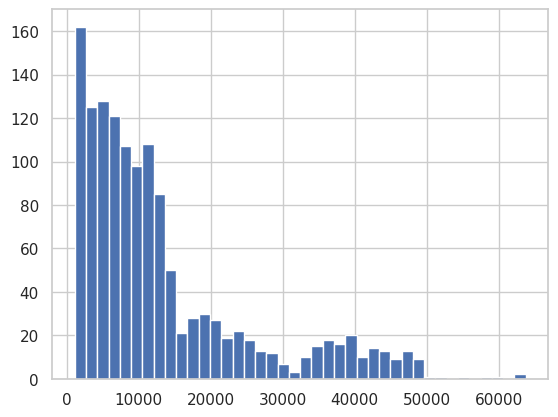

In [17]:
print(df.shape)
df.charges.hist(bins = 40)

Algo que analizar, según este gráfico, es entender qué está pasando con los datos arriba de los 50,000. Parece haber muy pocos datos de este lado.

In [19]:
display(df[df.charges>50000])
# If we want to delete these rows we do this
df = df[df.charges<50000]

,age,sex,bmi,children,smoker,region,charges
34,28,male,36.400,1,yes,southwest,51194.55914
543,54,female,47.410,0,yes,southeast,63770.42801
577,31,female,38.095,1,yes,northeast,58571.07448
819,33,female,35.530,0,yes,northwest,55135.40209
1146,60,male,32.800,0,yes,southwest,52590.82939
1230,52,male,34.485,3,yes,northwest,60021.39897
1300,45,male,30.360,0,yes,southeast,62592.87309


En este caso, al ser pocos datos (6 de 1338), eliminaremos estos datos atípicos. A modo didáctico producen más ruido en la predicción que se está intentando hacer en este ejercicio.

Sin embargo es importante aclarar que **NO SE DEBEN ELIMINAR** datos atípicos sin antes conocer a alguien que conozca o sea experto en los datos para que pueda guiarnos mejor sobre ellos.

## Viendo correlaciones
Ahora entendamos nuestros datos viendo cómo se distribuyen y correlacionan.

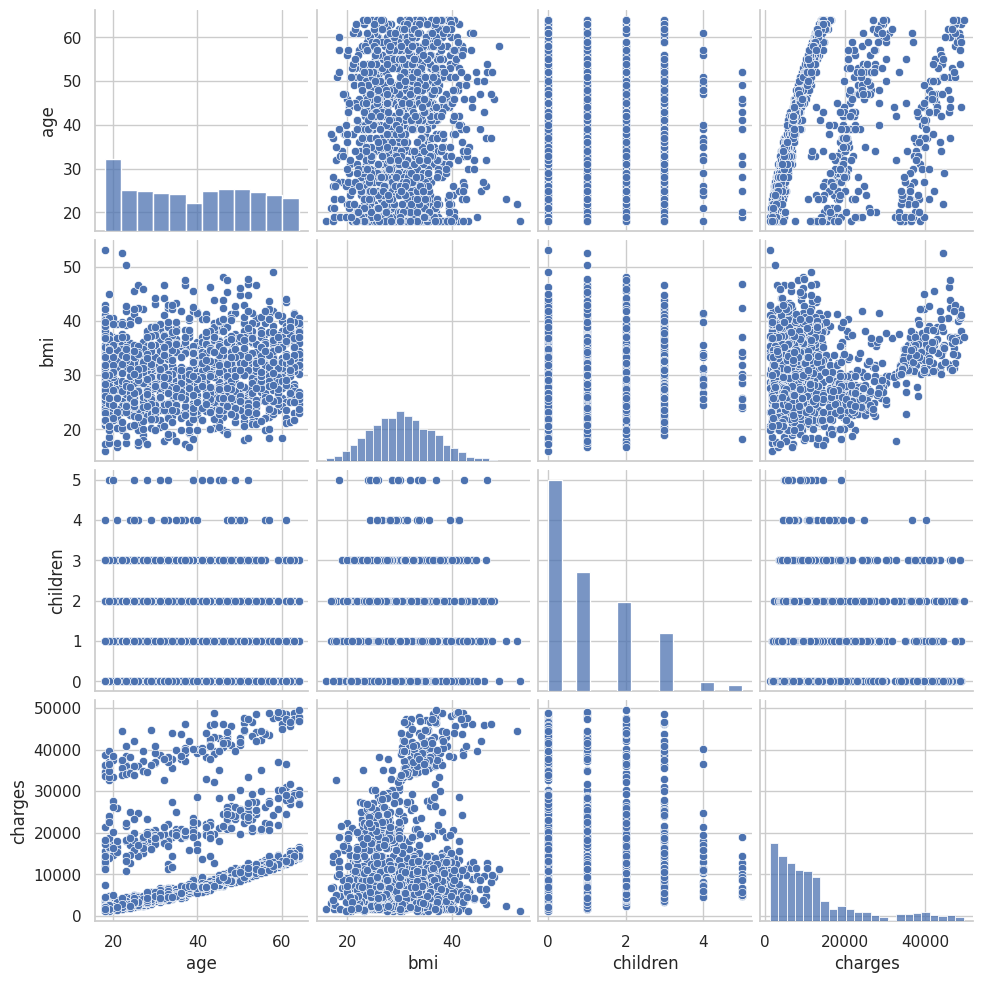

In [20]:
import matplotlib.pyplot as plt
sns.pairplot(df, height=2.5)
plt.show()

Puntos interesantes a ver:

- Hay 3 grupos de personas diferentes que se clasifican en edad / cargos, esto puede ser un punto a analizar después.

En general los valores se distribuyen de manera esperada. Con valores extremos en el caso de los cargos, sin embargo esto es de esperarse pues los cargos en los hospitales pueden variar mucho por quedarse un día más en el hospital o incluso por procedimientos extras.

- Parece que los datos están limpios, la variable de índice de masa corporal se distribuye de manera normal o gausiana, lo cual sería esperado en un índice de este tipo.

<Axes: >

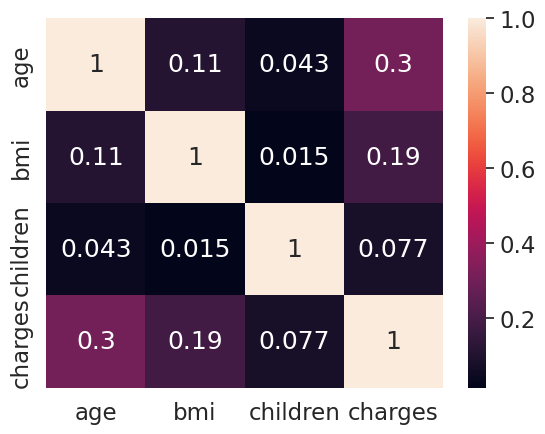

In [21]:
import numpy as np
numeric_cols = ['age', 'bmi', 'children', 'charges']
cm = np.corrcoef(df[numeric_cols].values.T)
sns.set(font_scale=1.5)
sns.heatmap(cm,annot=True, yticklabels=numeric_cols,xticklabels=numeric_cols)

## Utilizando las demás variables
Las demás variables son variables categoricas, sexo, fumador, región. Para poder utilizarlas utilizaremos la función **[get_dummies](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html)** de pandas.

Ahora la verás en acción

In [22]:
df = pd.get_dummies(df, columns=['sex','smoker','region'], drop_first=True)
df.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0,1,0,0,1
1,18,33.770,1,1725.55230,1,0,0,1,0
2,28,33.000,3,4449.46200,1,0,0,1,0
3,33,22.705,0,21984.47061,1,0,1,0,0
4,32,28.880,0,3866.85520,1,0,1,0,0


## Creando modelos
Primero se usará un modelo con todas las variables.

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [30]:
X_cols = list(set(df.columns)-set(['charges']))
X = df.drop(columns = ['charges'])
y = df[['charges']]

#X = df[X_cols].values
#y = df[y_col].values

# By default takes 75% of the data for training and 25% of the data for test
X_train, X_test, y_train, y_test = train_test_split(X,y)
# gets the median and standard deviation with the .fit
sc_x = StandardScaler().fit(X)
sc_y = StandardScaler().fit(y)

# Applies the transformation over all the variables
X_train = sc_x.transform(X_train)
X_test = sc_x.transform(X_test)
y_train = sc_y.transform(y_train)
y_test = sc_y.transform(y_test)

# Creates the LinearRegression model and uses the train variables for the fit function
model = LinearRegression()
model.fit(X_train,y_train)
# A prediction over the train data
y_pred = model.predict(X_test)

In [31]:
# It predicted 333 lines corresponding to the X_test size
y_pred.shape

(333, 1)

## Funciones de métricas
El siguiente punto es calcular las métricas del modelo.

In [32]:
import sklearn.metrics as metrics
mse = metrics.mean_squared_error(y_test,y_pred)
r2 = metrics.r2_score(y_test, y_pred)

print("r2 ", r2.round(4))
print("mse: ", mse.round(4))

r2  0.7773
mse:  0.2302


El siguiente código muestra un resumen general de los resultados.

In [33]:
from regressors import stats
# Cleans the model data
# We just need the value since it is delivered as a list
model.intercept_ = model.intercept_[0]
# Coeficients that exists from this model (w0,w1,w2,..)
# Allows the library stats to use this coef succesfuly
model.coef_ = model.coef_.reshape(-1)

In [34]:
# Allows the library to use this coef succesfuly
y_test = y_test.reshape(-1)

print("==========Summary==========")
stats.summary(model, X_test, y_test, X_cols)

==========Summary==========
Residuals:
   Min      1Q  Median     3Q    Max
-2.078 -0.1131  0.0971 0.2172 0.9188


Coefficients:
                  Estimate  Std. Error  t value   p value
_intercept       -0.001459    0.026393  -0.0553  0.955942
region_southeast  0.297342    0.026813  11.0894  0.000000
region_southwest  0.162693    0.027783   5.8558  0.000000
region_northwest  0.051185    0.026618   1.9229  0.055342
smoker_yes       -0.007771    0.026845  -0.2895  0.772407
bmi               0.788489    0.026819  29.4005  0.000000
sex_male         -0.027549    0.030308  -0.9090  0.364024
children         -0.030707    0.032836  -0.9352  0.350388
age              -0.034040    0.030482  -1.1167  0.264928
---
R-squared:  0.77729,    Adjusted R-squared:  0.77179
F-statistic: 141.35 on 8 features


Finalmente tenemos la función que calcula los residuales. Es importante notar que es una simple resta entre los valores reales y los predichos.

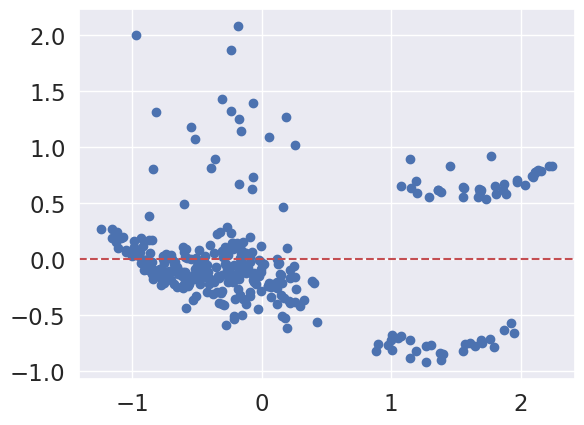

In [43]:
residuals = np.subtract(y_test, y_pred.reshape(-1))

plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

## Segundo modelo
Estos resultados de arriba son buenos, pero se pueden mejorar. Intentaremos hacer algunas transformaciones sobre las variables que pueden ser de utilidad.

In [44]:
# Create a copy of the original dataframe
df_second = df.copy()
# Squared age
df_second['age2'] = df_second.age**2
# Overweight variable. If the body mass index >= 30. it is 1 if true or 0 if false
df_second['sobrepeso'] = (df_second.bmi >= 30).astype(int)
# Overweight person and smoker.
df_second['sobrepeso*fumador'] = df_second.sobrepeso * df_second.smoker_yes

Analysing the second model

In [45]:
X_cols = ['sobrepeso*fumador', 'smoker_yes', 'age2', 'children']
y_col = ['charges']

X = df_second[X_cols].values
y = df_second[y_col].values

X_train, X_test, y_train, y_test = train_test_split(X,y)
sc_x = StandardScaler().fit(X)
sc_y = StandardScaler().fit(y)

X_train = sc_x.transform(X_train)
X_test = sc_x.transform(X_test)
y_train = sc_y.transform(y_train)
y_test = sc_y.transform(y_test)

model = LinearRegression(fit_intercept=False)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

In [46]:
mse = metrics.mean_squared_error(y_test,y_pred)
r2 = metrics.r2_score(y_test, y_pred)

print("r2 ", r2.round(4))
print("mse: ", mse.round(4))

r2  0.8786
mse:  0.118


In [47]:
model.coef_ = model.coef_.reshape(-1)

In [48]:
y_test = y_test.reshape(-1)

print("==========Summary==========")
stats.summary(model, X_test, y_test, X_cols)

==========Summary==========
Residuals:
    Min     1Q  Median     3Q    Max
-1.7393 0.0722  0.1126 0.1379 0.3812


Coefficients:
                   Estimate  Std. Error  t value   p value
_intercept         0.000000    0.018866   0.0000  1.000000
sobrepeso*fumador  0.499437    0.023933  20.8684  0.000000
smoker_yes         0.451556    0.023728  19.0303  0.000000
age2               0.329393    0.018611  17.6990  0.000000
children           0.069057    0.019000   3.6345  0.000323
---
R-squared:  0.87864,    Adjusted R-squared:  0.87716
F-statistic: 593.66 on 4 features


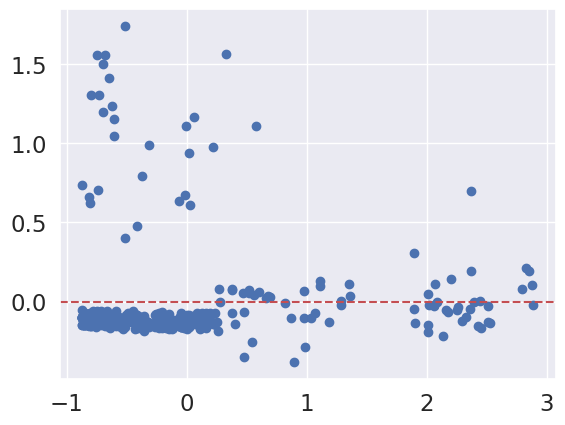

In [50]:
residuals = np.subtract(y_test, y_pred.reshape(-1))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.show()
